In [1]:
import torch
import model
import utils
import data
import torchvision.transforms as transforms
from torchvision.utils import make_grid, save_image

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
cnn = model.AlexNet(num_classes = 3).to(device)
cnn.load_state_dict(torch.load('checkpoint_min.pth'))

<All keys matched successfully>

In [4]:
utils

<module 'utils' from 'C:\\Users\\Sriram Pingali\\Desktop\\Radical Health\\utils.py'>

In [5]:
config = dict(model_type='alexnet', arch=cnn, layer_name='features_11')
config['arch'].to(device).eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4

In [6]:
from PIL import Image
from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

gradcam, gradcam_pp = [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]

In [7]:
dataset = data.dataset(image_root = './DRIMDB')
train_loader, val_loader = data.dataloader(dataset = dataset, batch_size = 16, validation_split = 0.2, shuffle_dataset = True)
wrong_paths = utils.evaluate(cnn, train_loader)

84.39306358381504


In [8]:
def preprocess(img_path):
    pil_img = Image.open(img_path)
    # pil_img = pil_img.convert('RGB')
    
    torch_img = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])(pil_img).to(device)
    normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]
    return(torch_img, normed_torch_img)

In [15]:
images = []
for img_path in wrong_paths:
    torch_img, normed_torch_img = preprocess(img_path)
    mask, _ = gradcam(normed_torch_img)
    heatmap, result = visualize_cam(mask, torch_img)

    mask_pp, _ = gradcam_pp(normed_torch_img)
    heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)
    
    images.extend([torch_img.cpu(), heatmap, heatmap_pp, result, result_pp])
    
grid_image = make_grid(images, nrow=5)

C:\Users\Sriram Pingali\Anaconda3\lib\site-packages\torch\nn\functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


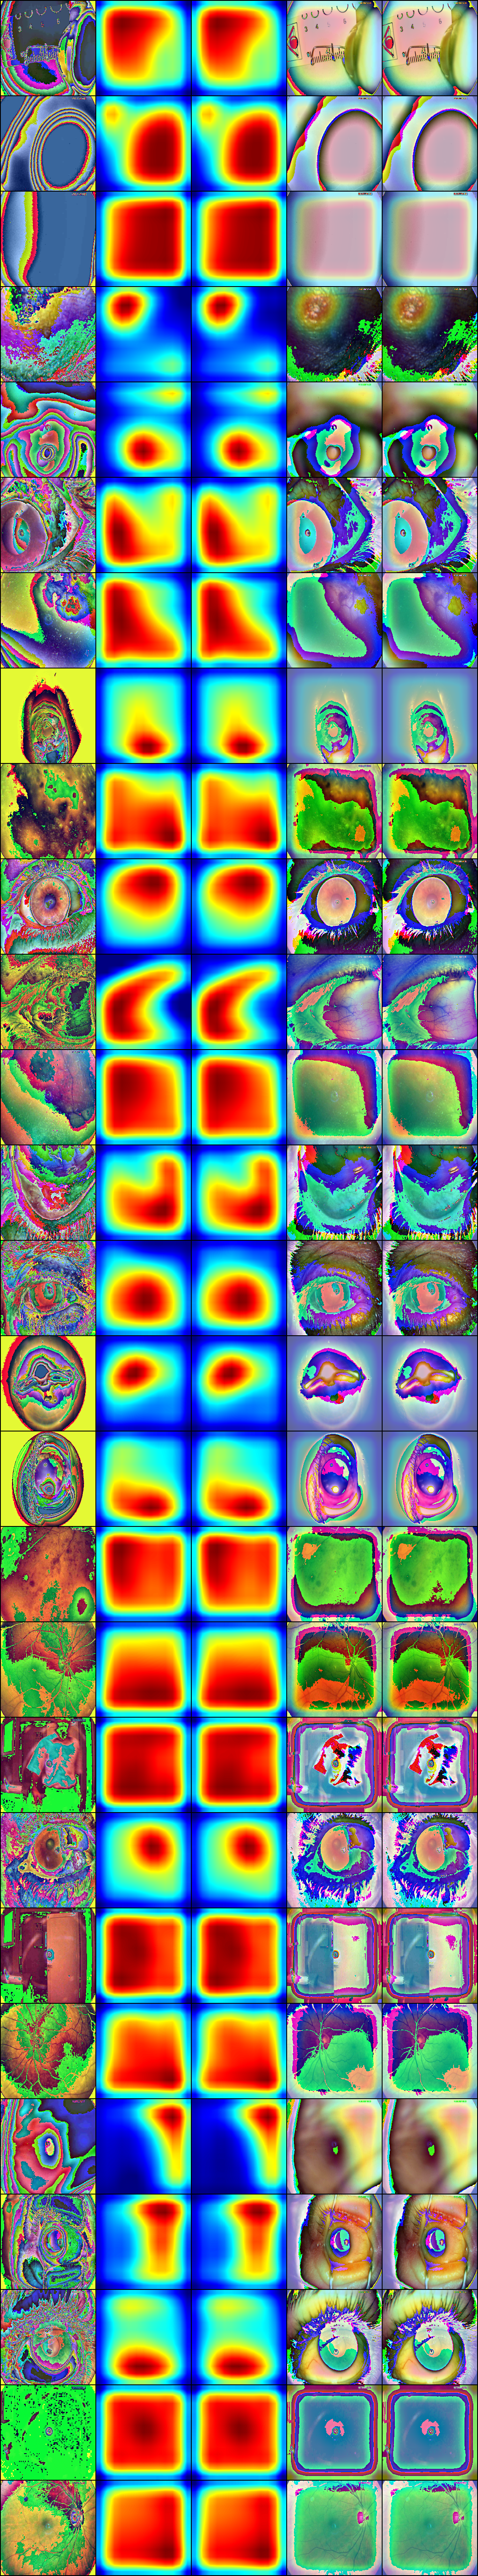

In [16]:
transforms.ToPILImage()(grid_image)